# Used Packages

In [1]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary
from random import sample

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [2]:
num_of_axis = 3  # number of geomagnetic channels
seq_len = 20  # length of sequence

num_of_classes = 4  # number of activity classes to be calibrated
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Data Loader

* source data: original untransformed data
* source label: activity class of the original data
* target data: transformed and calibrated data
* target label: activity class of the target-transformed data

In [3]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [4]:
def make_dataset(source_data, source_label, target_data, target_label):
    dataset = PairDataset(
        source_data = torch.tensor(source_data, dtype=torch.float),
        source_label = source_label,
        target_data = torch.tensor(target_data, dtype=torch.float),
        target_label = target_label,
    )
    return dataset

In [5]:
def make_dataloader(dataset, batch_size=32, shuffle=True):
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return dataloader

# Model Declaration

In [6]:
# Custom loss function to calculate the first derivative loss
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]

        # calculate the loss as the mean squared error of the derivative
        loss = mae_loss(d_source, d_target)

        return loss

In [7]:
# Initialize common loss functions
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [8]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag, epoch_ratio=None):
    imu_loss = mae_loss(z_imu, target_imu)
    mag_loss = torch.sqrt(mse_loss(predict_mag, target_mag))
    d1_loss = div_loss(predict_mag, target_mag)

    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))

    smag_limitation_loss = mae_loss(pred_total_mag, source_total_mag)
    tmag_limitation_loss = mae_loss(pred_total_mag, target_total_mag)

    if epoch_ratio == None:
        total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    else:
        total_loss = (imu_loss + mag_loss * (2 - epoch_ratio) + d1_loss * (1 + epoch_ratio)) / 4 + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

In [9]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    return mask.to(device)

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)

## Proposed Model

In [11]:
class OurProposedTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(OurProposedTransformer, self).__init__()

        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        self.mag_axis = num_of_axis

        self.acc_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
            PositionalEncoding(64, 0.1),
            nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        )

        self.lin_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
            PositionalEncoding(64, 0.1),
            nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        )

        self.gyr_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
            PositionalEncoding(64, 0.1),
            nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        )

        self.fusion = nn.Sequential(
            nn.Linear(192, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
        )

        self.mag_layer = nn.Sequential(
            nn.Linear(self.mag_axis, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
            PositionalEncoding(64, 0.1),
            nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        )

        self.acc_nn = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )

        self.lin_nn = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )

        self.gyr_nn = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )

        self.decoder  = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=4, dropout=0.1, batch_first=True), num_layers=1)

        self.mag_last = nn.Sequential(
           nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, num_of_axis),
        )

    def forward(self, source_imu, target_imu, source_mag):

        ### step 1
        h_acc = self.acc_layer(source_imu[:, :, 0:3])
        h_lin = self.lin_layer(source_imu[:, :, 3:6])
        h_gyr = self.gyr_layer(source_imu[:, :, 6:9])

        h_imu = self.fusion(torch.cat((h_acc, h_lin, h_gyr), 2))
        h_mag = self.mag_layer(source_mag)

        ### step 2
        h_acc = self.acc_nn(h_acc)
        h_lin = self.lin_nn(h_lin)
        h_gyr = self.gyr_nn(h_gyr)

        z_imu = torch.cat((h_acc, h_lin, h_gyr), 2)

        ### step 3
        pred_latent = self.decoder(h_imu, h_mag, tgt_mask=get_tgt_mask(self.seq_len))
        mag = self.mag_last(pred_latent)

        return z_imu, mag

In [12]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, num_of_axis)
    targ_mag = result[1].reshape(-1, num_of_axis)
    x = np.arange(len(pred_mag))

    loss = torch.sqrt(mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag))).item()

    fig = plt.figure(figsize=(15, 5))

    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'][:num_of_axis], ['tab:blue', 'tab:orange', 'tab:green'][:num_of_axis]):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)

    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)

    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [13]:
def train(dataloader, draw=False, epoch_ratio=1):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:11] + torch.randn_like(source_data[:, :, 2:11]) * 0.25
        source_mag = source_data[:, :, 11:(11 + num_of_axis)] + torch.randn_like(source_data[:, :, 11:(11 + num_of_axis)]) * 0.5
        source_total_mag = source_data[:, :, -1]

        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:11]
        target_mag = target_data[:, :, 11:(11 + num_of_axis)]
        target_total_mag = target_data[:, :, -1]

        # generate mag
        z_imu, predict_mag = model(source_imu, target_imu, source_mag)

        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag, epoch_ratio)

        # backward
        gen_loss.backward()
        optimizer.step()

        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])

    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)

    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [14]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axis)]
            source_total_mag = source_data[:, :, -1]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axis)]
            target_total_mag = target_data[:, :, -1]

            # generate mag
            z_imu, predict_mag = model(source_imu, target_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])

    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)

    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [15]:
def output_eval(model, dataloader):
    model.eval()

    results = []
    class_results = []
    class_labels = []

    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axis)]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axis)]
            z_imu, predict_mag = model(source_imu, target_imu, source_mag)

            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()

            results.extend(zip(predict_mag, target_mag, source_label, target_pos))

            diff = np.absolute(predict_mag.reshape(len(predict_mag), -1, num_of_axis) - target_mag.reshape(len(target_mag), -1, num_of_axis)).mean(axis=1)

            class_results.extend(diff)
            class_labels.extend(source_label)

    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [16]:
def show_result(model, dataloader, plot_num=10):
    results, cres, clabel = output_eval(model, dataloader)
    print(results.shape, cres.shape, clabel.shape)

    if num_of_axis == 3:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy, dz = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
        dx, dy, dz = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

    elif num_of_axis == 2:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')
        dx, dy = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')

    for rs in sample(list(results), plot_num):
        plot_result(rs)

# Experiment

### Data format description
The shape of a single sequence is: (seq_len, channels)
* seq_len: length of the sequence
* channels:
    * 0:2 - position
    * 2:11 - acceleration(3-axis), linear acceleration(3-axis), gyroscope(3-axis)
    * 11:14 - geomagnetic field(3-axis)

The data format of a batch data is: (source_data, source_label, target_data, target_label)
* source data: original untransformed data
* source label: activity class of the original data
* target data: transformed and calibrated data
* target label: activity class of the target-transformed data

In [17]:
# train_dataset = Make Your Dataset Here
# valid_dataset = Make Your Dataset Here
# train_loader = make_dataloader(train_dataset, batch_size=32, shuffle=True)
# valid_loader = make_dataloader(valid_dataset, batch_size=32, shuffle=False)

### Fake data generator

only used to test the correctness of the function.

In [18]:
# Function to generate fake data for testing
def make_fake_data(num=100, length=20, channel=15, classes=4):
    fake_data = []
    for c in range(classes):
        for i in range(num):
            # Generate random data and add an offset to differentiate between samples and classes
            data = np.random.rand(length, channel) + i * 0.1 + c * 0.1
            fake_data.append(data)
    return np.array(fake_data)

# Function to generate a DataLoader with fake data for testing
def make_fake_dataloader(num=100, length=20, channel=15, classes=4, batch_size=32, shuffle=True):
    fake_source_data = make_fake_data(num, length, channel, classes=4)
    fake_source_label = (np.ones(num) * np.arange(classes).reshape(-1, 1)).flatten()
    fake_target_data = make_fake_data(num, length, channel, classes=4)
    fake_target_label = np.zeros(num * classes)
    fake_dataset = make_dataset(fake_source_data, fake_source_label, fake_target_data, fake_target_label)
    fake_dataloader = make_dataloader(fake_dataset, batch_size=batch_size, shuffle=shuffle)
    return fake_dataloader

classes = {0: 'horizontal', 1: 'front_pocket', 2: 'pocket', 3: 'swing', 4: 'target'}

fake_train_dataloader = make_fake_dataloader(num=1000, length=20, channel=15, batch_size=32, shuffle=True)
fake_valid_dataloader = make_fake_dataloader(num=100, length=20, channel=15, batch_size=32, shuffle=False)

train_loader = fake_train_dataloader
valid_loader = fake_valid_dataloader

In [19]:
model = OurProposedTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)

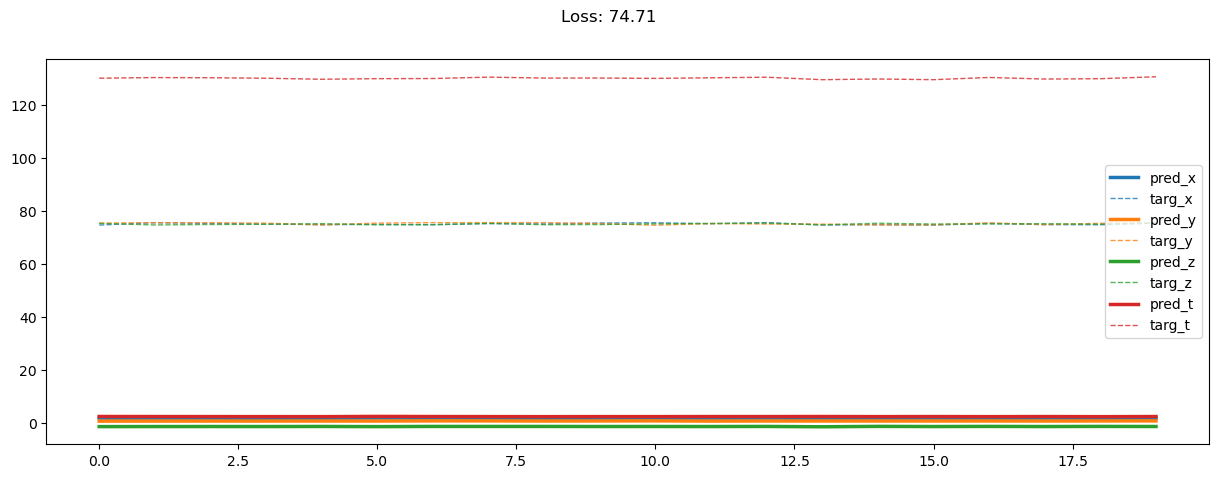

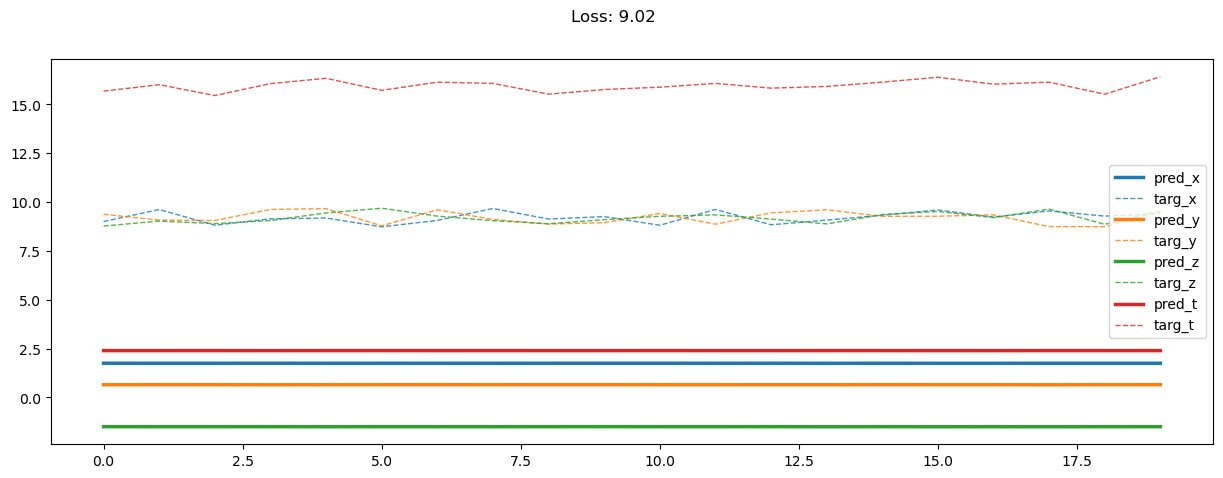

00000: train loss:  98.616, imu loss: 50.470, mag loss: 57.901, div loss: 33.128, slim: 48.764, tlim: 48.766
       valid loss:  15.624, imu loss:  5.490, mag loss:  6.046, div loss:  0.408, slim:  3.680, tlim:  3.679


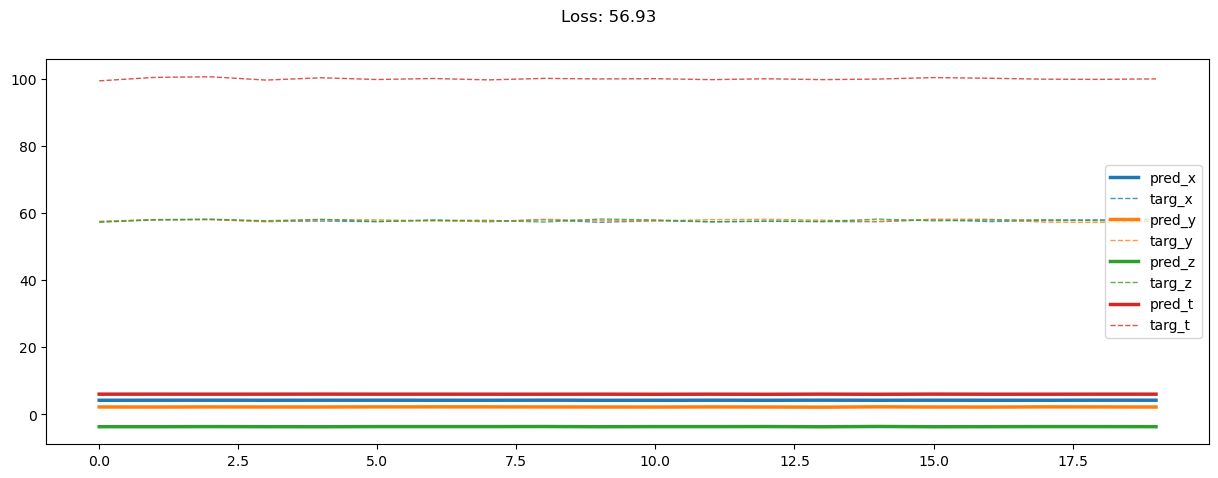

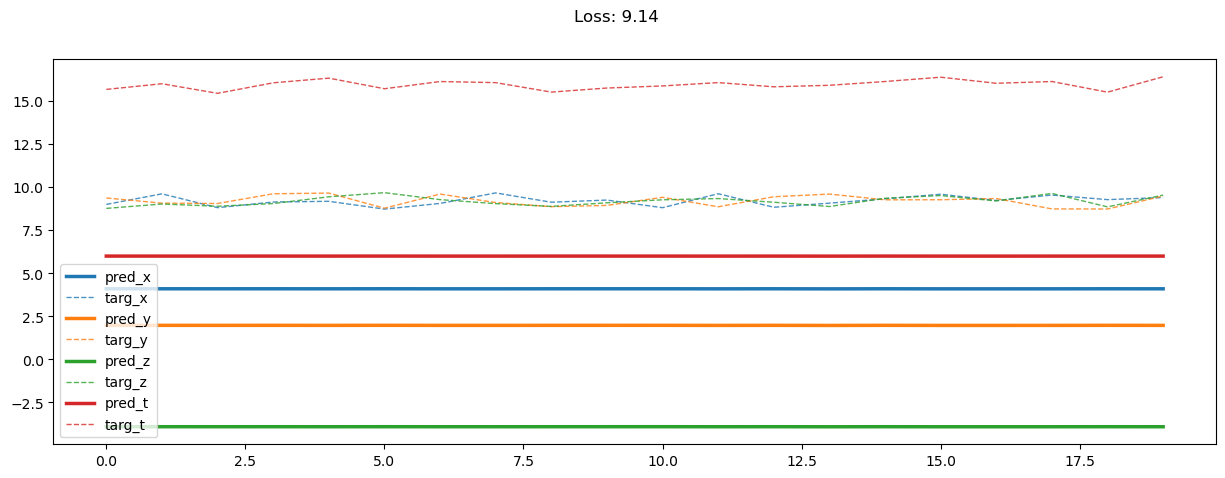

00010: train loss:  91.795, imu loss: 47.250, mag loss: 57.452, div loss: 33.107, slim: 45.007, tlim: 45.009
       valid loss:  11.198, imu loss:  2.848, mag loss:  6.581, div loss:  0.401, slim:  1.373, tlim:  1.367


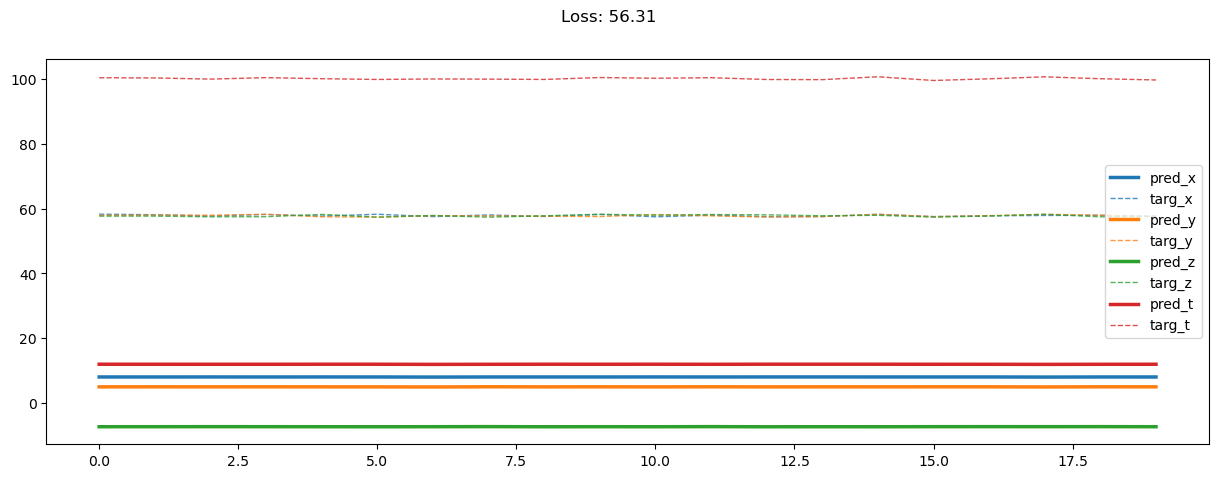

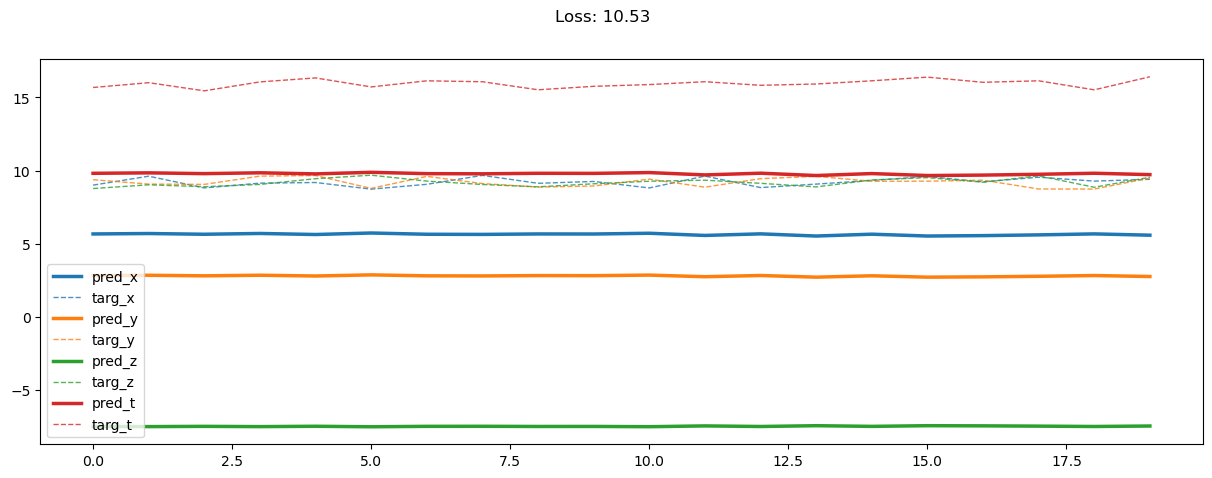

00020: train loss:  83.087, imu loss: 43.490, mag loss: 56.845, div loss: 32.690, slim: 39.643, tlim: 39.646
       valid loss:   9.492, imu loss:  1.169, mag loss:  7.552, div loss:  0.404, slim:  0.371, tlim:  0.365


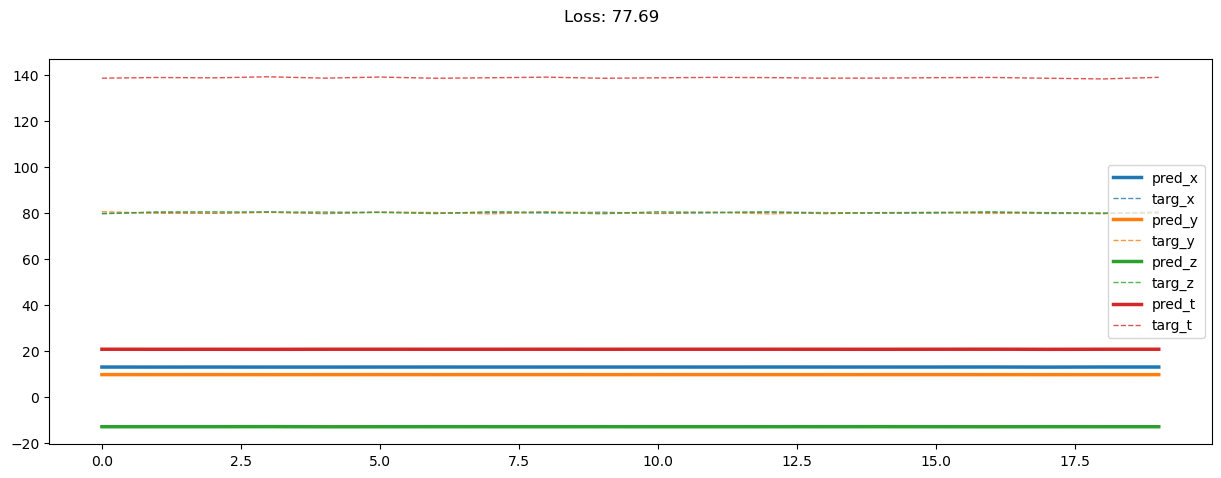

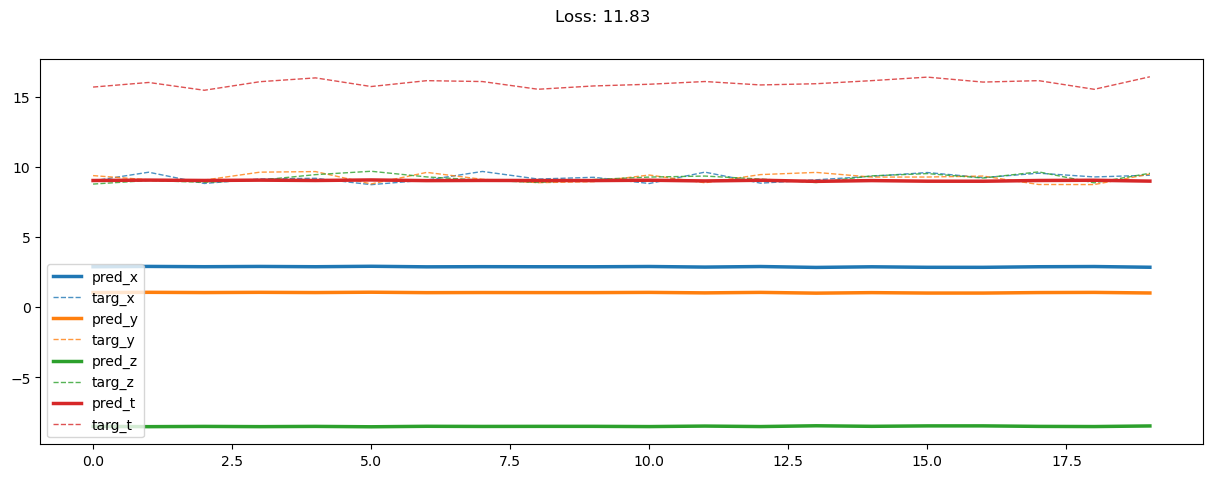

00030: train loss:  72.308, imu loss: 38.620, mag loss: 56.453, div loss: 32.332, slim: 32.372, tlim: 32.374
       valid loss:   9.905, imu loss:  0.743, mag loss:  8.426, div loss:  0.423, slim:  0.321, tlim:  0.310


In [20]:
EPOCH = 30
draw = False

for epoch in range(EPOCH+1):
    draw = ((epoch) % 10 == 0)

    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw, epoch / EPOCH)

    if epoch % 10 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

# Plot the Calibrated Geomagnetic Field

(4000, 4) (4000, 3) (4000,)
           loss name|   diff x   diff y   diff z      avg
     horizontal loss:    39.23    42.24    62.48    47.98
   front_pocket loss:    39.32    42.33    62.60    48.08
         pocket loss:    39.40    42.42    62.70    48.18
          swing loss:    39.49    42.51    62.82    48.27
        average loss:    39.36    42.38    62.65    48.13


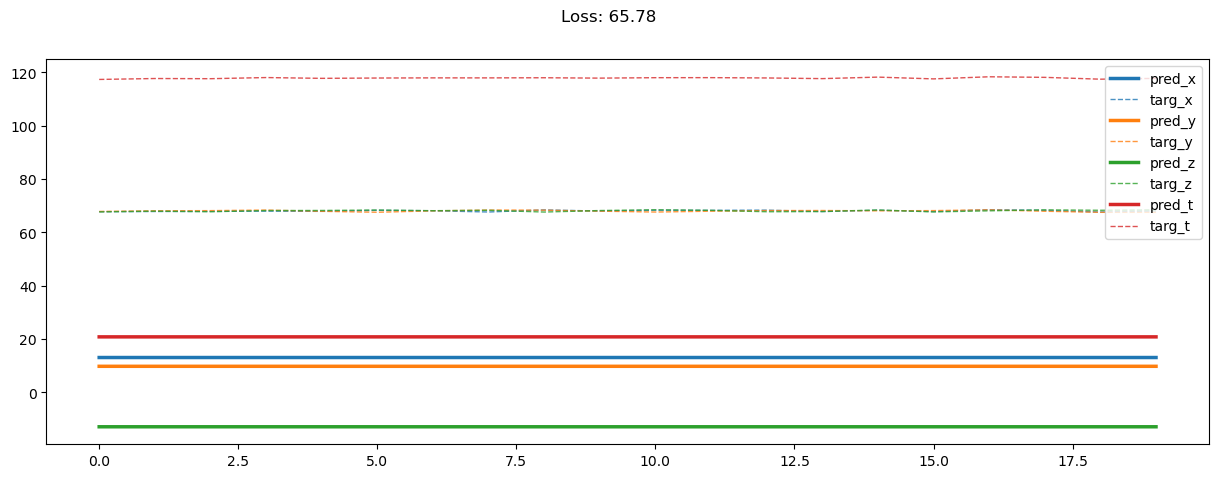

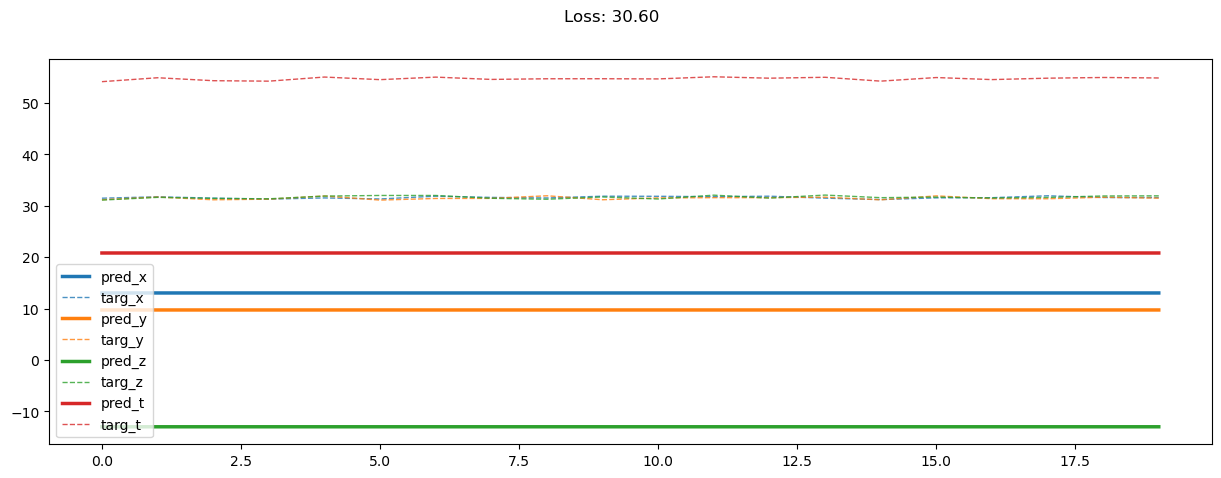

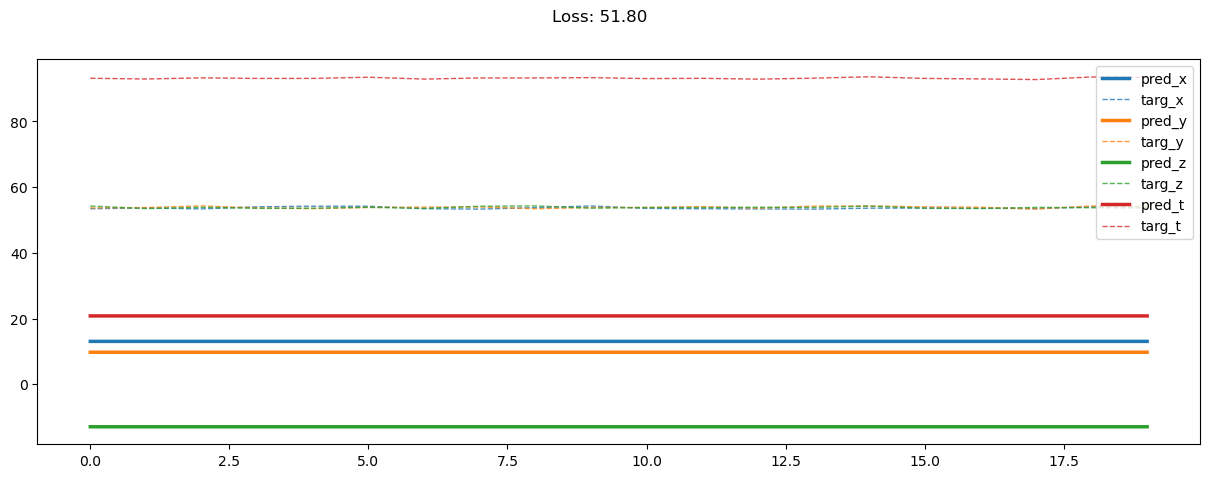

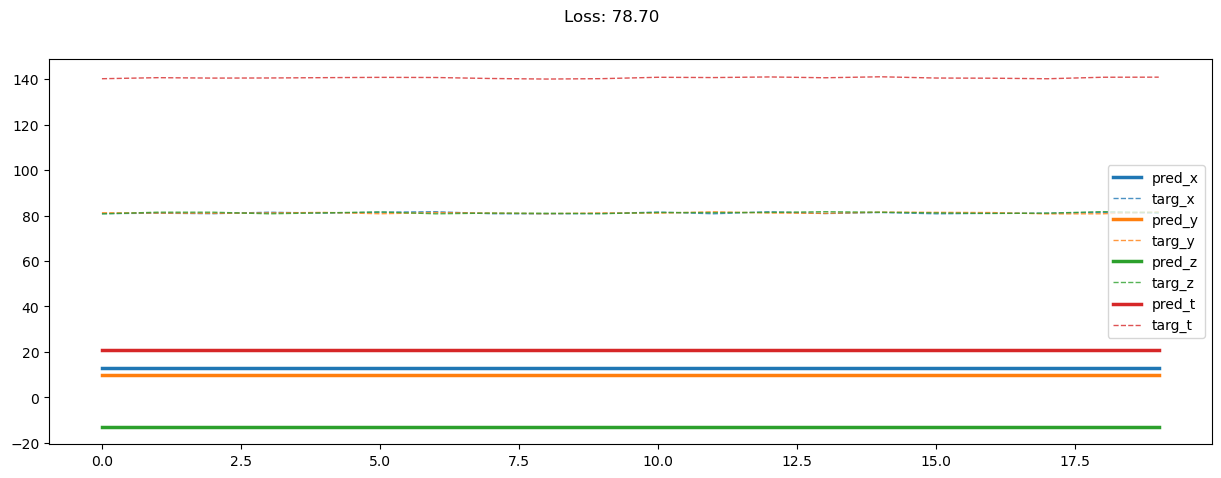

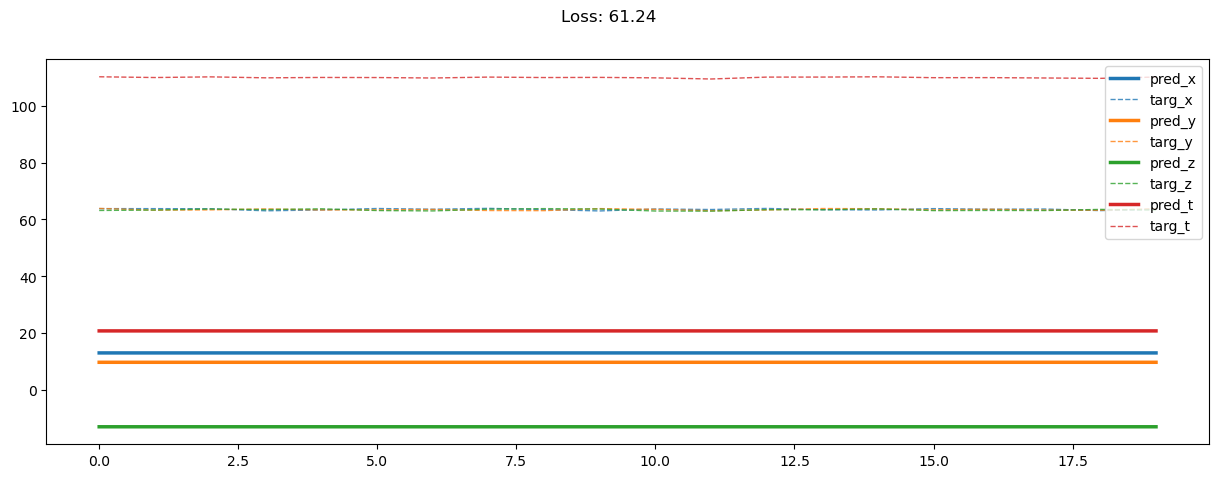

In [21]:
show_result(model, train_loader, plot_num=5)

(400, 4) (400, 3) (400,)
           loss name|   diff x   diff y   diff z      avg
     horizontal loss:     5.29     6.25    10.27     7.27
   front_pocket loss:     5.35     6.34    10.47     7.38
         pocket loss:     5.39     6.40    10.65     7.48
          swing loss:     5.44     6.47    10.84     7.59
        average loss:     5.37     6.36    10.56     7.43


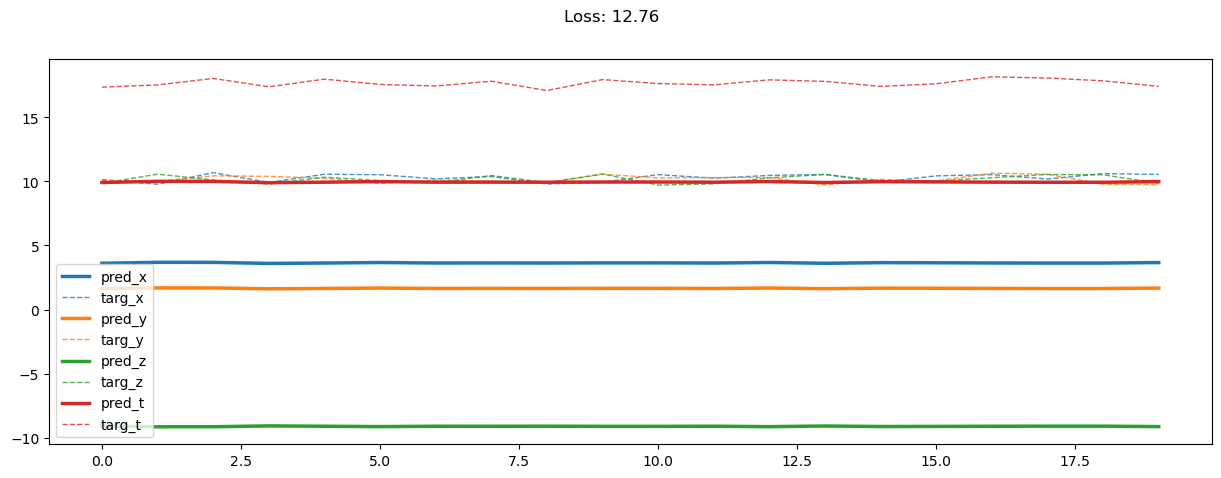

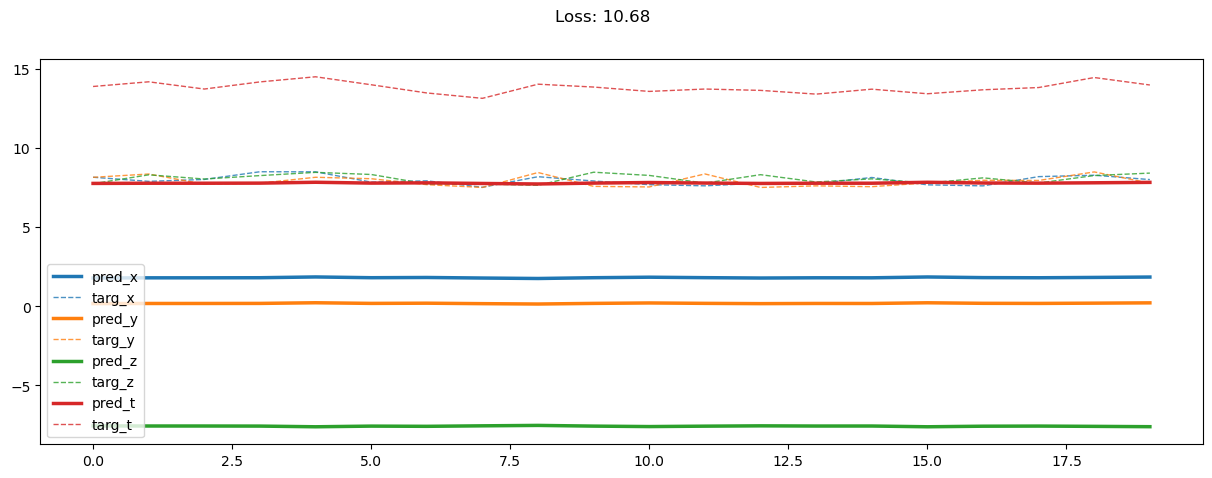

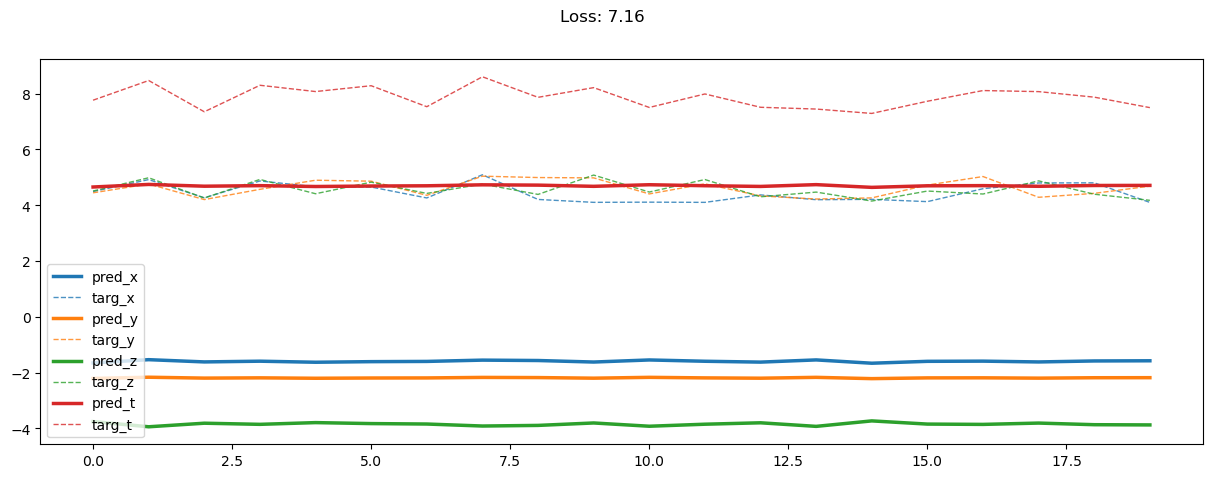

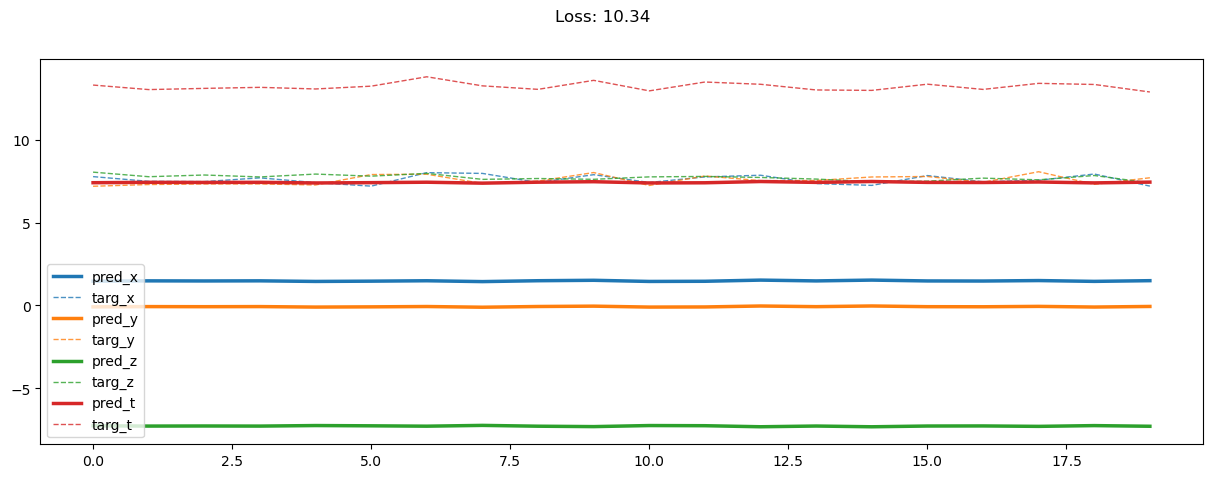

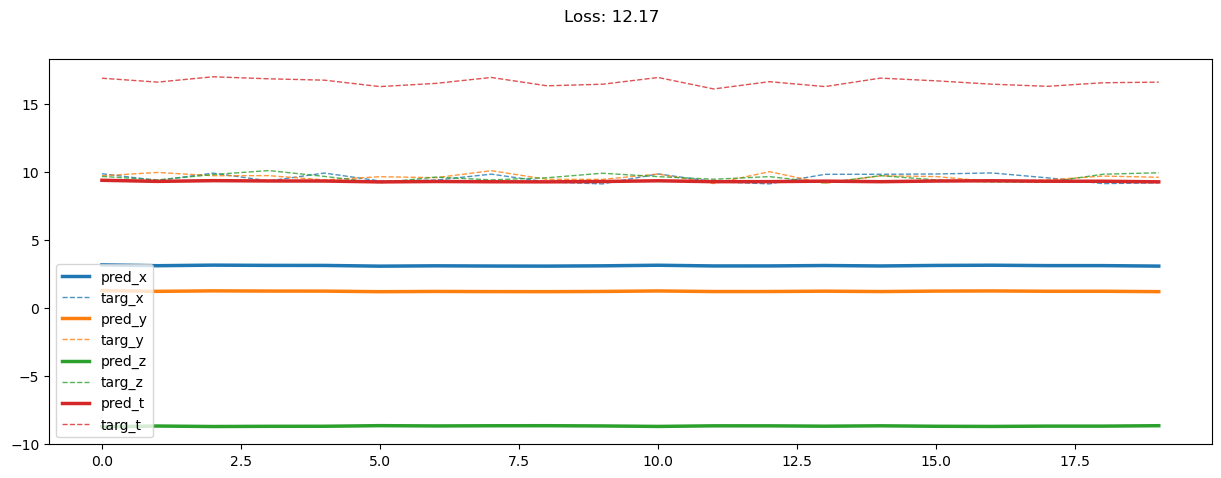

In [22]:
show_result(model, valid_loader, plot_num=5)

# Save Model

In [23]:
torch.save(model, f'./calibration_model.pt')